In [ ]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
import numpy as np
from numpy.random import seed

import tensorflow as tf
import tensorflow as tf

import keras
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K

import matplotlib.pyplot as plt
import random 

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [ ]:
seed(1)
tf.set_random_seed(1)

##### Some functions

In [ ]:
def plot_loss(trained_model):
    
    keys   = trained_model.history.keys()
    losses = sorted([a for a in keys if a.endswith('_loss') ])
    accs   = sorted([a for a in keys if a.endswith('_acc') ])
    
    plt.figure()
    plt.plot(trained_model.history[losses[0]], label = 'Loss 1')
    plt.plot(trained_model.history[losses[1]], label = 'Loss 2')
    plt.plot(trained_model.history['loss'], label = 'Loss')
    # plt.axis([0, 100, 0, 0.5])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(b=True, which='major', color='#c2c2c2', linestyle='-')
    plt.legend(fontsize = 10)
    
def plot_constellation(input_layer, encoder_2_layer, k):
    
    my_encoder = Model(input_layer, encoder_2_layer)
    
    eye_matrix = np.eye(k) 
    points = my_encoder.predict(eye_matrix) 
    print(points)

    # Plot
    plt.title('Constellation')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.plot(points[:,0], points[:,1], 'k.', markersize=10)
    plt.grid(True)
    
    return points
    
def plot_constellation_3d(input_layer, encoder_2_layer, k):
    
    my_encoder = Model(input_layer, encoder_2_layer)
    
    eye_matrix = np.eye(k) 
    points = my_encoder.predict(eye_matrix) 
    print(points)
    
    # This import registers the 3D projection, but is otherwise unused.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2])

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

In [ ]:
# Model??

##### Parameters

In [ ]:
# Bits
k1 = 2          
k2 = 2

k = 2**(k1+k2)

# Constellation Size
M1 = 2**k1
M2 = 2**k2

# EbN0
SNR1 = 10**(12/10)
SNR2 = 10**(2/10) 

# Channel Reuse
n_channel = 2

#a = 0.5
#b = 0.5

# Size of Input data
N = 100000 

##### Generate data

In [ ]:
'''def generate_data(k, N):
    label = np.random.randint(k,size=N)
    data = []
    for i in label:
        temp = np.zeros(k)
        temp[i] = 1
        data.append(temp)
    data = np.array(data)
    return data

SyntaxError: ignored

In [ ]:
mapping = {0: (0,0), 1: (0,1), 2: (0,2), 3: (0,3),
           4: (1,0), 5: (1,1), 6: (1,2), 7: (1,3),
           8: (2,0), 9: (2,1), 10:(2,2), 11:(2,3),
           12:(3,0), 13:(3,1), 14:(3,2), 15:(3,3)}

In [ ]:
def generate_data_v2(k1, k2, N, mapping):
    labels = np.random.randint(2**(k1+k2), size=N)
    
    data_f = []
    data_2 = []
    
    for i in labels:
        # Full data
        temp = np.zeros(2**(k1+k2))
        temp[i] = 1
        data_f.append(temp)
        
        # Data of user 2
        temp = np.zeros(2**k2)
        temp[mapping[i][1]] = 1
        data_2.append(temp)
        
    return np.array(data_f), np.array(data_2)

In [ ]:
data, data_2 = generate_data_v2(k1, k2, N, mapping)

In [ ]:
data_2

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [ ]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

##### Model

In [ ]:
''' def create_model(k, n):
    # Input
    input_signal = Input(shape=(k,)) # Expected input in batches of size M1 + M2

    # Mutual Encoder (64L,2L,PN)

    encoded = Dense(64, activation='linear')(input_signal) # Linear
    encoded1 = Dense(n, activation='linear')(encoded) # Linear 
    #encoded2 = Lambda(lambda x: np.sqrt(n)*K.l2_normalize(x,axis=1))(encoded1) # energy constraint - forms a circle
    encoded2 = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded1) # average power constraint

    # Channel (AWGN with different SNRs)
    channel1 = GaussianNoise(np.sqrt(1/(2*SNR1)))(encoded2)
    channel2 = GaussianNoise(np.sqrt(1/(2*SNR2)))(encoded2)
                                                  

    # Decoder 1 (128L,64R,32R,S)
    u1_decoded = Dense(128, activation='linear')(channel1) 
    u1_decoded1 = Dense(64, activation='relu')(u1_decoded)
    u1_decoded2 = Dense(32, activation='relu')(u1_decoded1)
    u1_decoded3 = Dense(16, activation='softmax')(u1_decoded2) 

    # Decoder 2 (128L,64R,32R,S)
    u2_decoded = Dense(128, activation='linear')(channel2)
    u2_decoded1 = Dense(64, activation='relu')(u2_decoded)
    u2_decoded2 = Dense(32, activation='relu')(u2_decoded1)
    u2_decoded3 = Dense(4, activation='softmax')(u2_decoded2)

    # Model
    return Model(input_signal,  [u1_decoded3, u2_decoded3]), input_signal, encoded2

SyntaxError: ignored

In [ ]:
def create_model_v2(k1, k2, n):
    
    M = 2**(k1+k2)
    M2 = 2**k2
    
    # Input
    input_signal = Input(shape=(k,)) # Expected input in batches of size M1 + M2

    # Mutual Encoder (64L,2L,PN)

    encoded = Dense(64, activation='linear')(input_signal) # Linear
    encoded1 = Dense(n, activation='linear')(input_signal) # Linear 
    #encoded2 = Lambda(lambda x: np.sqrt(n)*K.l2_normalize(x,axis=1))(encoded1) # energy constraint - symbols lie on a unit circle
    encoded2 = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded1) # average power constraint

    # Channel (AWGN with different SNRs)
    channel1 = GaussianNoise(np.sqrt(1/(2*SNR1)))(encoded2)
    channel2 = GaussianNoise(np.sqrt(1/(2*SNR2)))(encoded2)

    # Decoder 1 (128L,64R,32R,S)
    u1_decoded = Dense(128, activation='linear')(channel1) 
    u1_decoded1 = Dense(64, activation='relu')(u1_decoded)
    u1_decoded2 = Dense(32, activation='relu')(u1_decoded1)
    u1_decoded3 = Dense(M, activation='softmax')(u1_decoded2) 

    # Decoder 2 (128L,64R,32R,S)
    u2_decoded = Dense(128, activation='linear')(channel2)
    u2_decoded1 = Dense(64, activation='relu')(u2_decoded)
    u2_decoded2 = Dense(32, activation='relu')(u2_decoded1)
    u2_decoded3 = Dense(M2, activation='softmax')(u2_decoded2)

    # Model
    return Model(input_signal,  [u1_decoded3, u2_decoded3]), input_signal, encoded2

In [ ]:
''''autoencoder, in_0, en_2 = create_model(k, n_channel)

# Optimizer
sgd = SGD(lr=0.1)

# Compilation 
autoencoder.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])


SyntaxError: ignored

In [ ]:
''' Comments:
    - QPSK + QPSK
    - Works for learning rate = 0.1, not for 0.001
    - Clusters form further away and closer within themselves for large delta SNR as expected 
    - E.g., SNR1 = 22 db, SNR2 = 1 dB
'''


autoencoder, in_0, en_2 = create_model_v2(k1, k2, n_channel)

sgd = SGD(lr=0.1)

autoencoder.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
print (autoencoder.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           dense_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 2)            0           lambda_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
buzz = autoencoder.fit(data, [data, data_2],
                epochs=20,
                batch_size=100,
                verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
100000/100000 [==============================] - 2s 24us/step - loss: 1.2331 - dense_6_loss: 0.5470 - dense_10_loss: 0.6861 - dense_6_accuracy: 0.8124 - dense_10_accuracy: 0.7024
Epoch 2/20
100000/100000 [==============================] - 2s 20us/step - loss: 0.7226 - dense_6_loss: 0.1258 - dense_10_loss: 0.5968 - dense_6_accuracy: 0.9553 - dense_10_accuracy: 0.7452
Epoch 3/20
100000/100000 [==============================] - 2s 21us/step - loss: 0.6897 - dense_6_loss: 0.1138 - dense_10_loss: 0.5760 - dense_6_accuracy: 0.9600 - dense_10_accuracy: 0.7573
Epoch 4/20
100000/100000 [==============================] - 2s 21us/step - loss: 0.6636 - dense_6_loss: 0.1141 - dense_10_loss: 0.5495 - dense_6_accuracy: 0.9596 - dense_10_accuracy: 0.7656
Epoch 5/20
100000/100000 [==============================] - 2s 21us/step - loss: 0.5869 - dense_6_loss: 0.1183 - dense_10_loss: 0.4686 - dense_6_

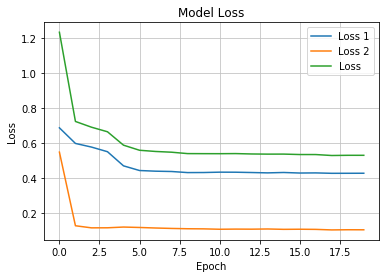

In [ ]:
plot_loss(buzz)

[[-0.35764468 -1.7870275 ]
 [-1.2313137   1.00628   ]
 [ 0.7143415   1.039585  ]
 [ 1.5329741   0.3467783 ]
 [ 0.17410146 -1.2130475 ]
 [-0.89762926  0.26322734]
 [ 0.11954619  0.5854104 ]
 [ 1.2316984  -0.9710851 ]
 [-0.19913998 -0.5900541 ]
 [-1.7480628   0.42842388]
 [-0.14730313  1.3023409 ]
 [ 1.7403687  -0.38485533]
 [-0.76302046 -1.1242772 ]
 [-1.4667627  -0.28499928]
 [ 0.4603633   1.7990657 ]
 [ 0.8934427  -0.21724646]]


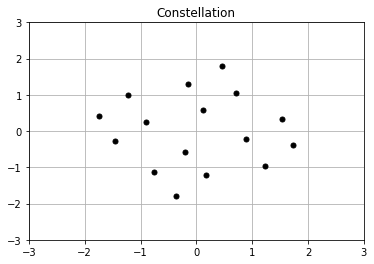

In [ ]:
a = plot_constellation(in_0, en_2, k)

In [ ]:
#plot_constellation_3d(in_0, en_2, k)

In [ ]:

plt.title('QPSK+QPSK, ΔSNR = 20dB')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot(a[:,0], a[:,1], 'k.', markersize=10)
plt.grid(True)

In [ ]:
UE1encoder = Model(input_signal, UE1encoded2)

encoded_input = Input(shape=(2*n_channel,))
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
UE1decoder = Model(encoded_input, deco)

In [ ]:
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

In [ ]:
tf.__version__